In [1]:
import tifffile
import scipy
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
from skimage.morphology import skeletonize
from sklearn.feature_extraction.image import img_to_graph, grid_to_graph
# from sklearn.feature_extraction.image import _make_edges_3d
from scipy import sparse

In [20]:
img = tifffile.imread('test_data/2020-06-30_17-47-20_chemotaxis_worm4_original-2.tif')

Text(0.5, 1.0, 'Original image')

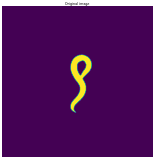

In [21]:
%matplotlib inline
plt.figure(figsize=(10,10),dpi=20)
plt.axis('off')
plt.imshow(img)
plt.title('Original image')

## Test full pipeline function

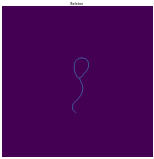

In [22]:
from skimage.morphology import skeletonize
skel=skeletonize(np.array(img,dtype=bool))
plt.figure(figsize=(10,10),dpi=20)
plt.axis('off')
plt.imshow(skel)
plt.title("Skeleton")
plt.show()

In [23]:
from remove_cycle_from_skeleton import skeletonize_and_remove_cycle
# Find the nodes for head and tail starting from pixel annotation
head_ij = np.array((310, 300))
tail_ij = np.array((265, 405))


final_img = skeletonize_and_remove_cycle(img, head_ij, tail_ij, True)

Found multiple intersection points... this algorithm may not work
Trying with only the first intersection node


Text(0.5, 1.0, 'Skeleton with cycle removed')

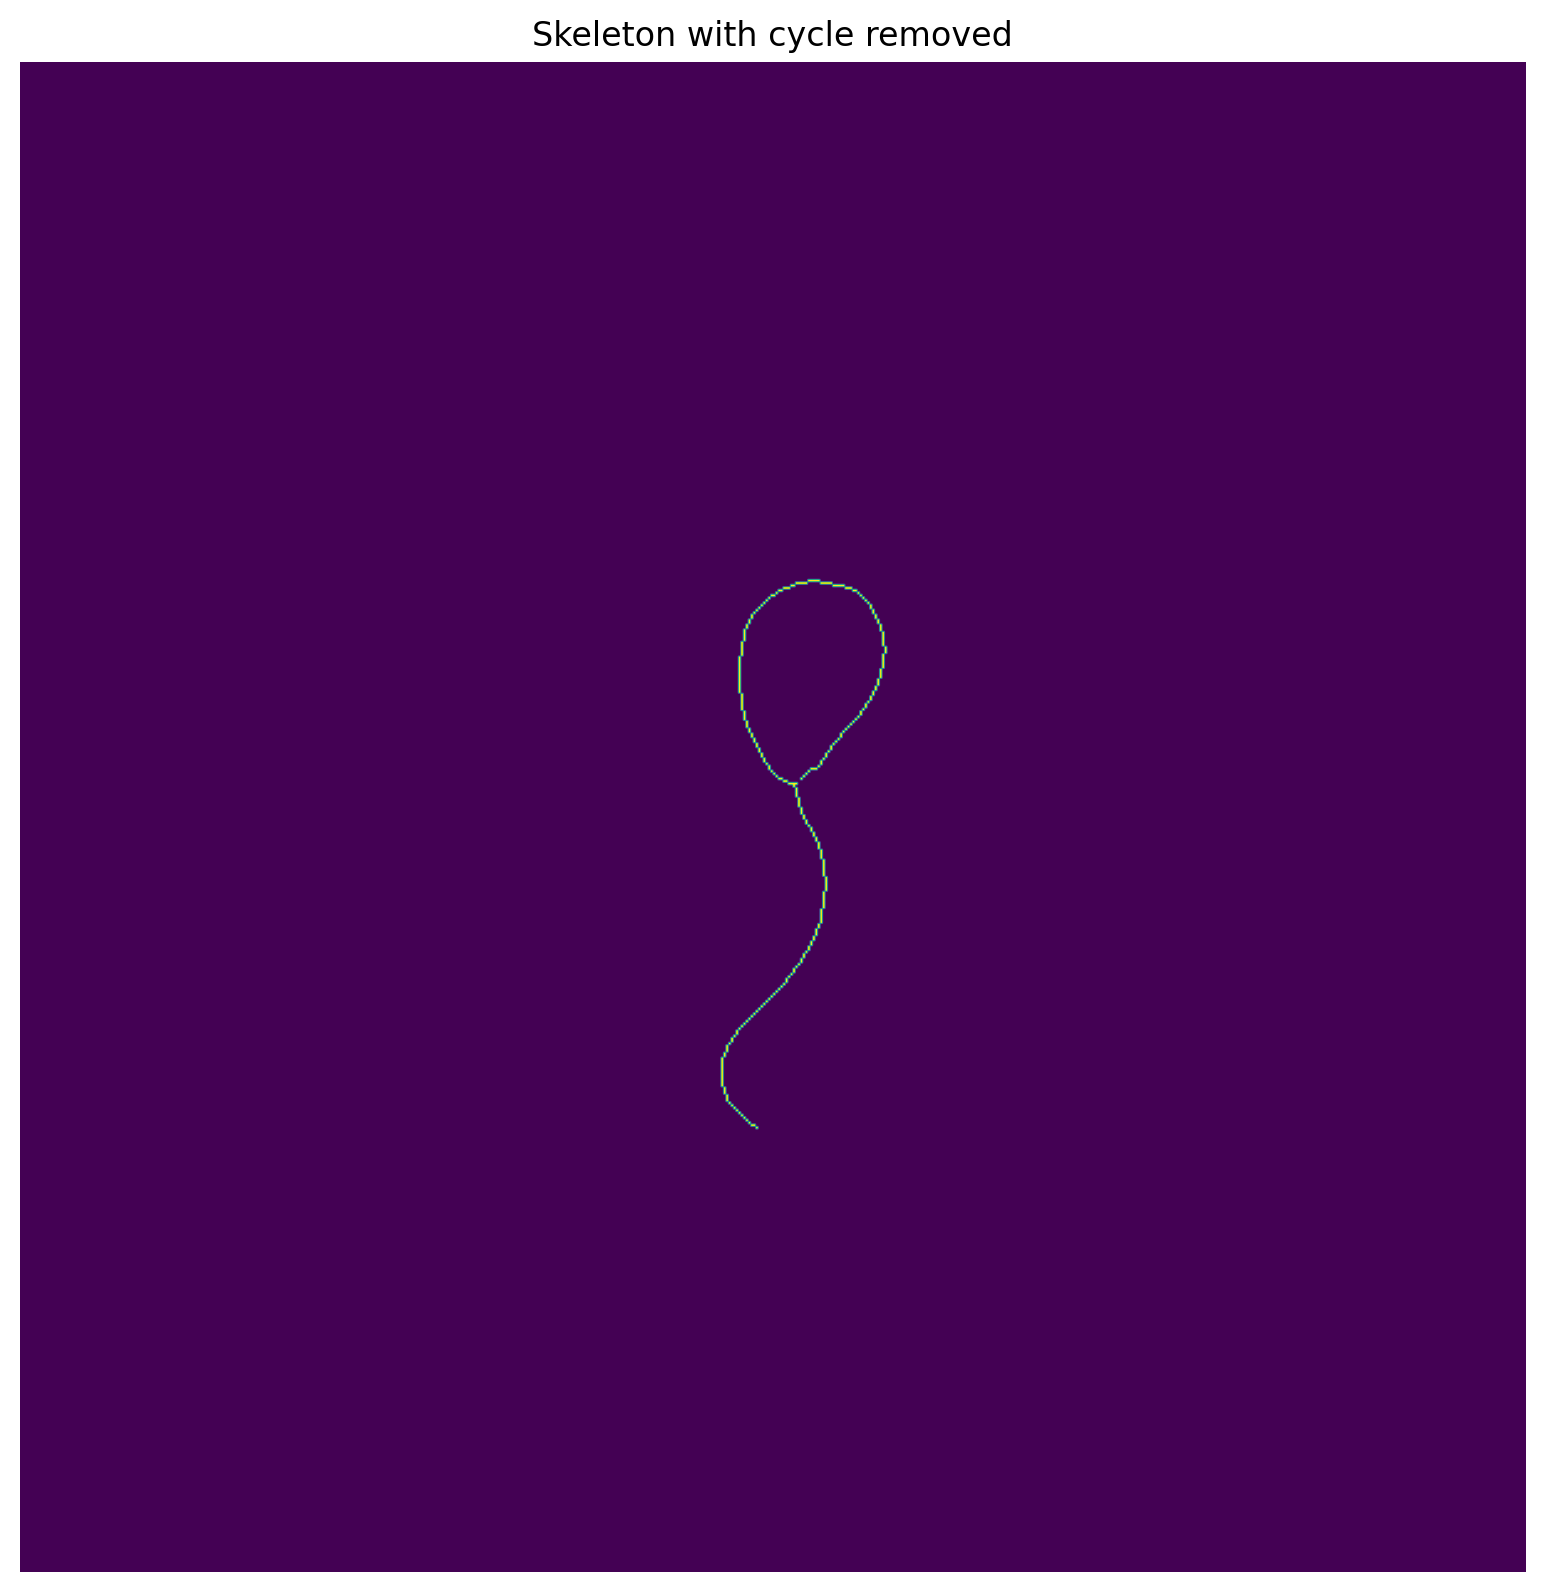

In [24]:
%matplotlib inline
plt.figure(figsize=(10,10),dpi=200)
plt.axis('off')
plt.imshow(final_img)
plt.title("Skeleton with cycle removed")

(250.0, 390.0)

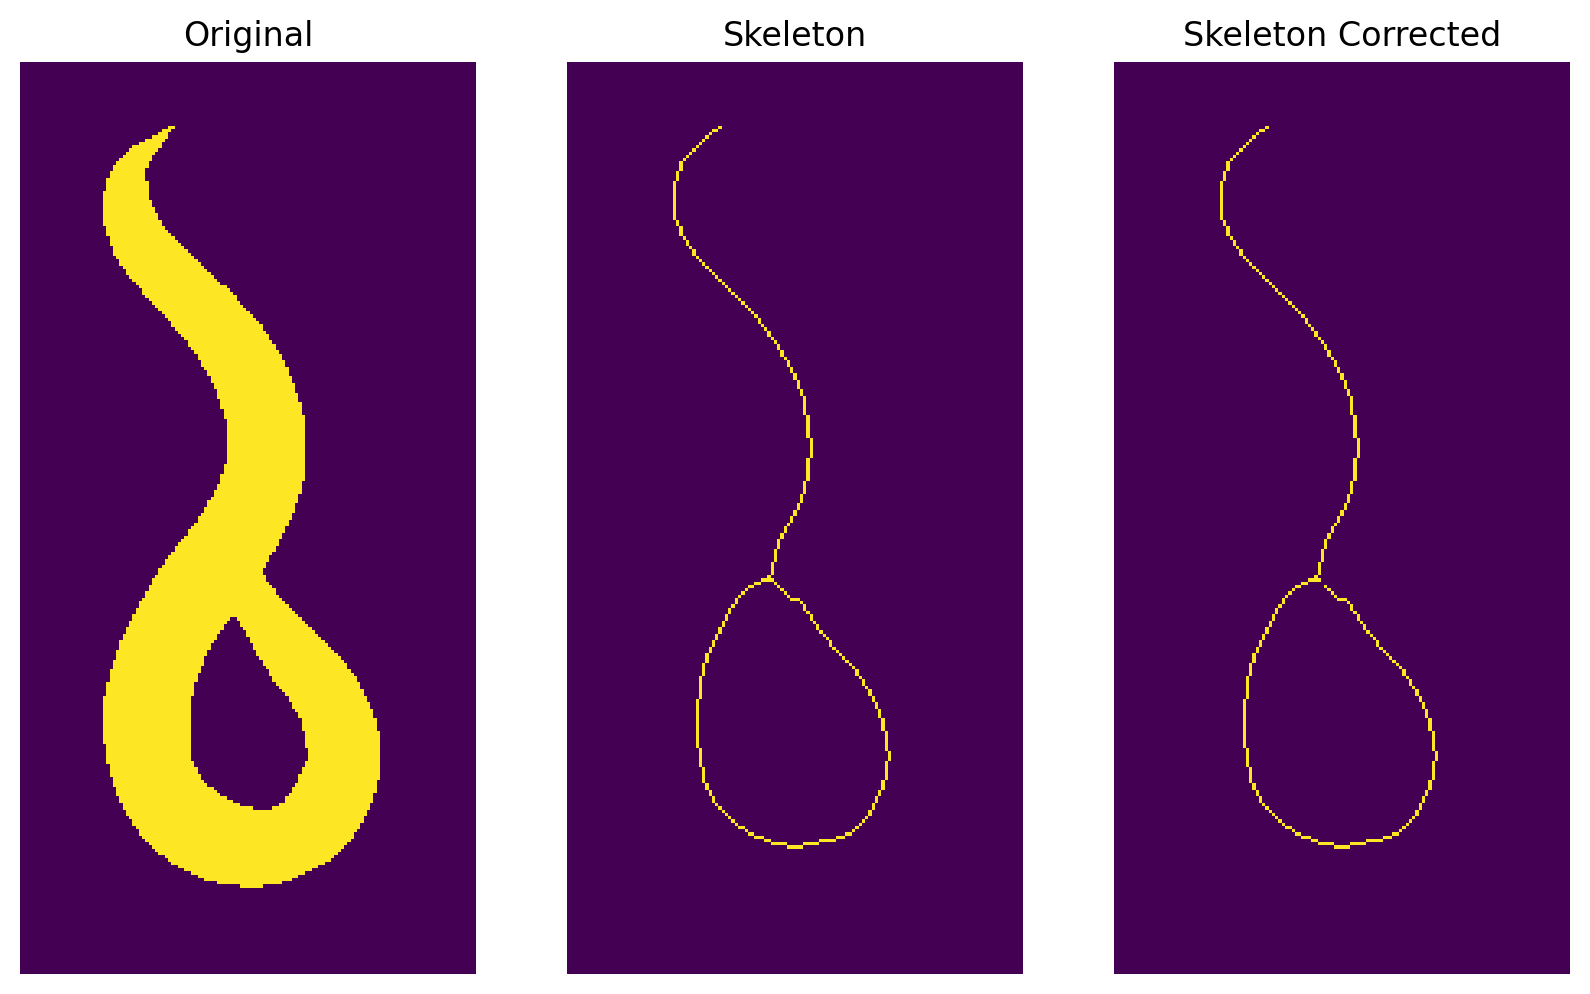

In [25]:
plt.subplots(figsize=(10,10),dpi=200)
plt.subplot(1,3,1)
plt.imshow(img)
plt.axis('off')
plt.title('Original')
plt.ylim([170,450])
plt.xlim([250,390])
plt.subplot(1,3,2)
plt.imshow(skel)
plt.title('Skeleton')
plt.axis('off')
plt.ylim([170,450])
plt.xlim([250,390])
plt.subplot(1,3,3)
plt.imshow(final_img)
plt.title('Skeleton Corrected')
plt.axis('off')
plt.ylim([170,450])
plt.xlim([250,390])

In [3]:
np.array((310, 300))

array([310, 300])

In [6]:
import pandas as pd
hdf5_filepath='/groups/zimmer/Ulises/wbfm/chemotaxis_assay/2020_Only_behaviour/all_good_hdf5/2020-06-05_16-46-41_worm1-channel-0-bigtiffDLC_resnet50_HeadTailAug10shuffle1_777500_filtered.h5'
df=pd.read_hdf(hdf5_filepath)

In [10]:
idx=0

In [18]:
scorer=df.columns.get_level_values(0)[0]

x=df.loc[idx][scorer,'Head','x']

In [19]:
y=df.loc[idx][scorer,'Head','y']

In [21]:
np.array((x,y))

array([282.84194946, 470.11746216])

In [ ]:
#open hdf5 file
#open tiff writer object
#open tiff reader object
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize


import os
import tifffile as tiff
import cv2

from remove_cycle_from_skeleton import skeletonize_and_remove_cycle


main='/groups/zimmer/Ulises/wbfm/chemotaxis_assay/2020_Only_behaviour/'
hdf5_filepath=os.path.join(main,'all_good_hdf5/2020-07-01_10-10-48_control_worm1-channel-0-bigtiffDLC_resnet50_HeadTailAug10shuffle1_777500_filtered.h5')
df=pd.read_hdf(hdf5_filepath)
scorer=df.columns.get_level_values(0)[0]

#input binary file
input_filepath=os.path.join(main,'binary_all/2020-07-01_10-10-48_control_worm1-channel-0-binary.tiff')
#outpupath where to save
output_filepath='/groups/zimmer/Ulises/code/centerline_outputs/2020-07-01_10-10-48_control_worm1-channel-0-binary_contiguous2.tiff'

with tiff.TiffWriter(output_filepath, bigtiff=True) as output_tif:
    with tiff.TiffFile(input_filepath, multifile=False) as tif:
        #for our data there would be only one series
        for idx,page in enumerate(tif.pages):
            img=page.asarray()
            head_ij=np.array((df.loc[idx][scorer,'Head','x'],df.loc[idx][scorer,'Head','y']))
            tail_ij=np.array((df.loc[idx][scorer,'Tail','x'],df.loc[idx][scorer,'Tail','y']))
            #plt.imshow(img)
            #plt.show()
            #skel=skeletonize(np.array(img,dtype=bool))
            #plt.imshow(skel)
            #plt.show()
            #annotated_img=img.copy()
            #cv2.circle(annotated_img,(int(df.loc[idx][scorer,'Head','x']), int(df.loc[idx][scorer,'Head','y'])),10, (150,150,150), 2)

            #cv2.circle(annotated_img,(int(df.loc[idx][scorer,'Tail','x']), int(df.loc[idx][scorer,'Tail','y'])),10, (150,150,150), 2)
            #plt.imshow(annotated_img)
            #plt.show()
            final_img = skeletonize_and_remove_cycle(img, head_ij, tail_ij, True)
            
            output_tif.write(final_img, photometric='minisblack', contiguous=True)
            print('if it gives and error with contiguous=True,set to False')

# Individual functions (DEPRECATED)

Text(0.5, 1.0, 'skeletonized')

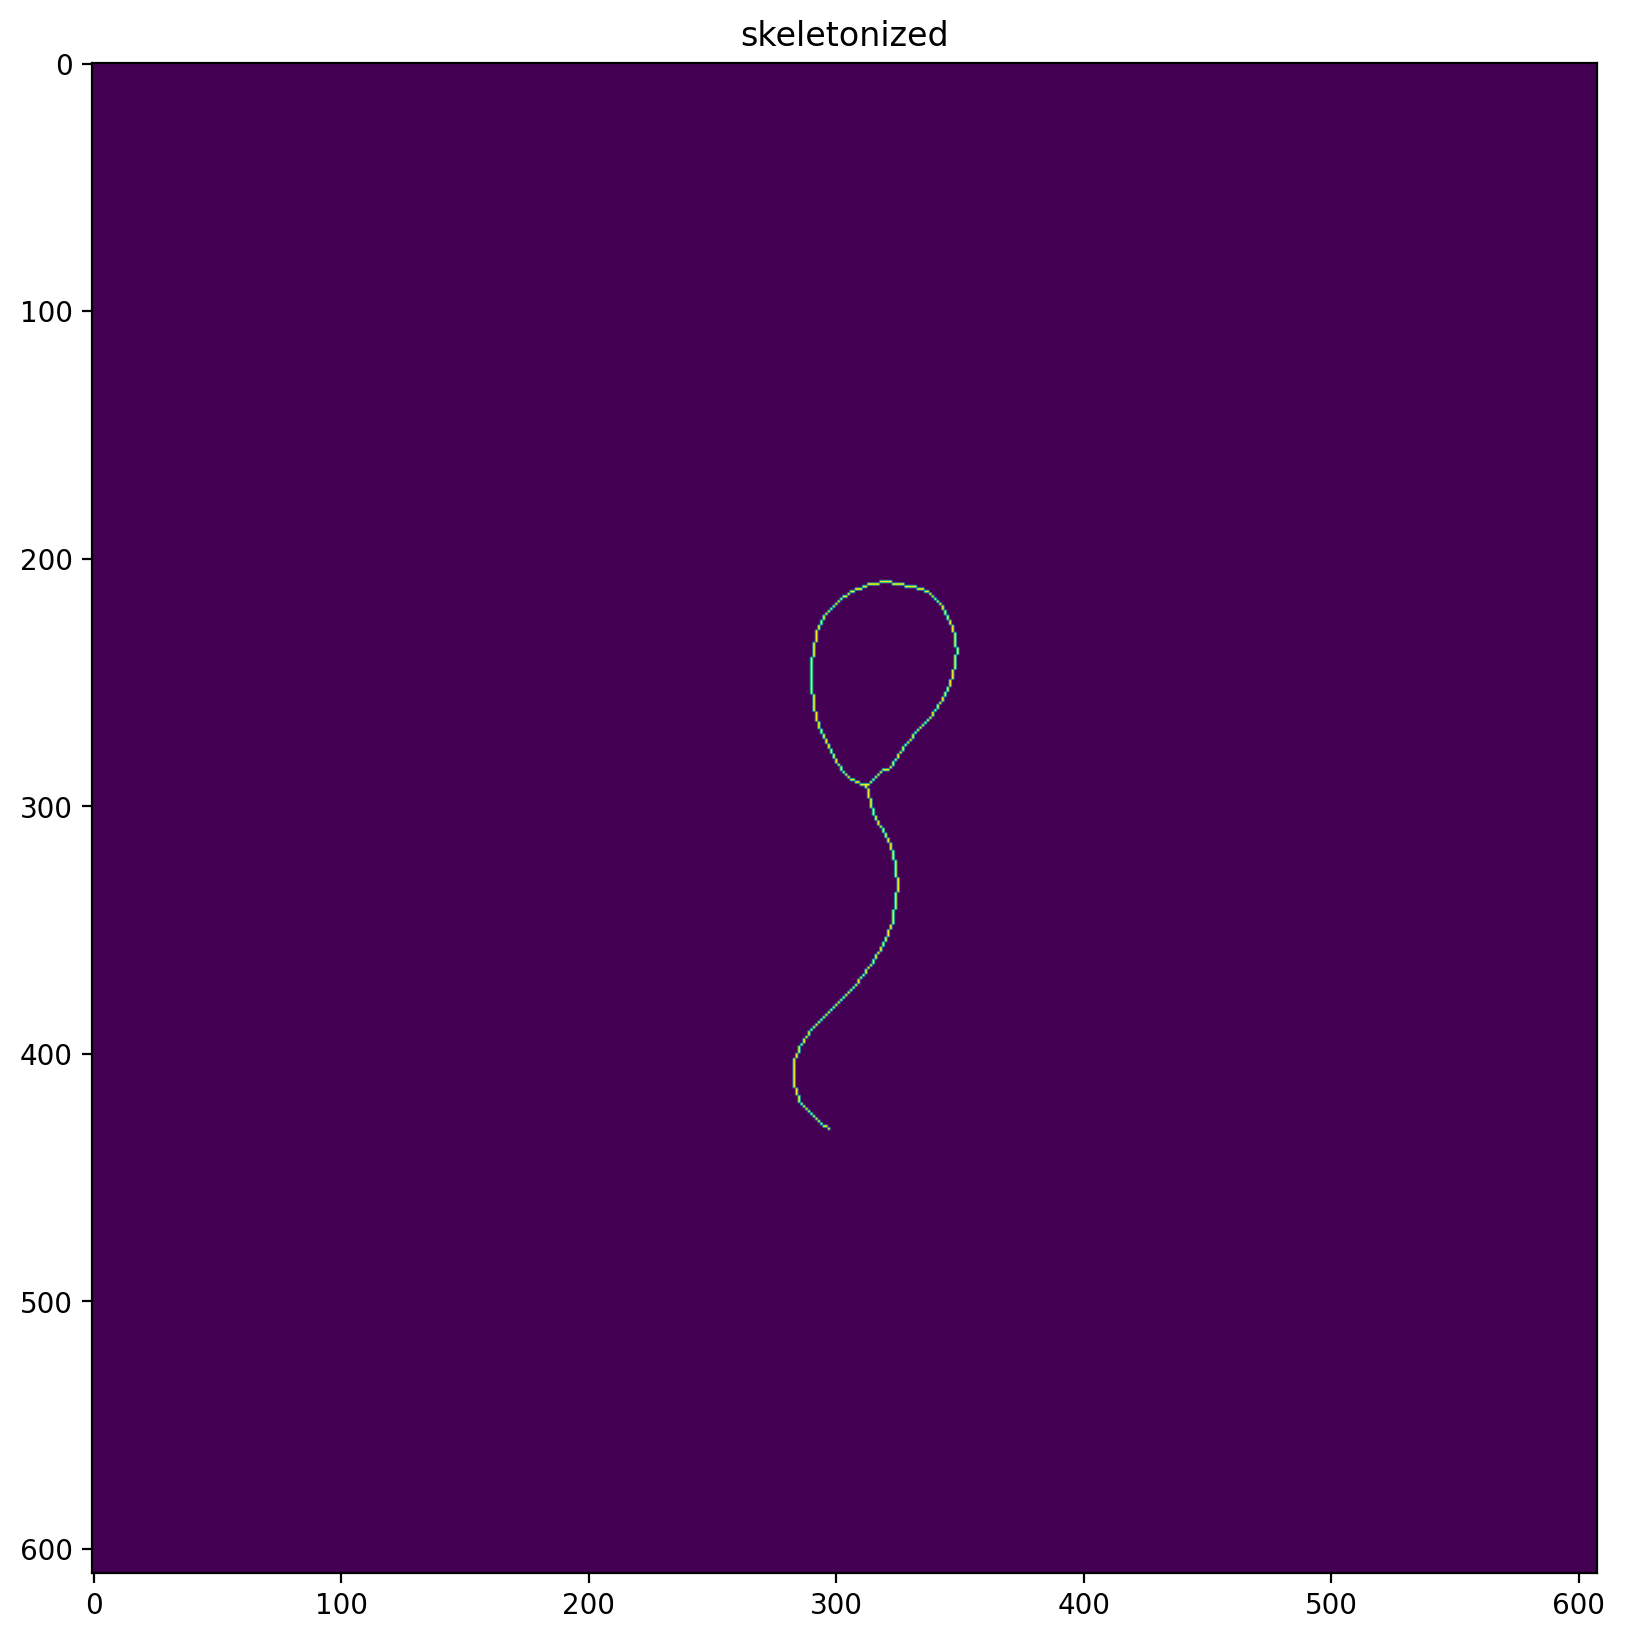

In [4]:
%matplotlib inline
img_sk = skeletonize(np.array(img,dtype=bool))
plt.figure(figsize=(10,10), dpi=200)
plt.imshow(img_sk)
plt.title("skeletonized")

In [5]:
def pixel_neighbours(img, p):
    """Returns the indices of the pixel neighbors"""
    rows, cols = img.shape

    i, j = p[0], p[1]

    rmin = i - 1 if i - 1 >= 0 else 0
    rmax = i + 1 if i + 1 < rows else i

    cmin = j - 1 if j - 1 >= 0 else 0
    cmax = j + 1 if j + 1 < cols else j

    neighbours = []
    for x in range(rmin, rmax + 1):
        for y in range(cmin, cmax + 1):
            neighbours.append([x, y])
    neighbours.remove([p[0], p[1]])

    return neighbours


def my_img_to_graph(img):
    
    n_x, n_y = img.shape
    n_vertices = n_x*n_y
    edges = []
    
    for i in range(n_x):
        for j in range(n_y):
            p = (i,j)
            if not img[p[0],p[1]] > 0:
                continue
            neighbors = pixel_neighbours(img, p)
            p_flat = np.ravel_multi_index(p, (n_x, n_y))
            for n in neighbors:
                weight = img[n[0],n[1]]
                if weight > 0:
                    n_flat = np.ravel_multi_index(n, (n_x, n_y))
                    edges.append([p_flat, n_flat, weight])
    return edges

In [6]:
# adj = img_to_graph(np.array(img_sk, dtype='uint8'))
# adj
edges = my_img_to_graph(img_sk)

In [7]:
G = nx.Graph()
G.add_weighted_edges_from(edges)

In [8]:
# %matplotlib inline
# nx.draw_kamada_kawai(G, with_labels=True)

In [9]:
# Find the nodes for head and tail starting from pixel annotation
head_ij = np.array((310, 300))
tail_ij = np.array((265, 405))

head_node = None
head_dist = np.Inf
tail_node = None
tail_dist = np.Inf

for n in G.nodes():
    this_ij = np.unravel_index(n, img_sk.shape)
    tmp_dist = np.linalg.norm(head_ij - this_ij)
    if tmp_dist < head_dist:
        head_node = n
        head_dist = tmp_dist
    tmp_dist = np.linalg.norm(tail_ij - this_ij)
    if tmp_dist < tail_dist:
        tail_node = n
        tail_dist = tmp_dist
print(f"Found head and tail nodes: {head_node}, {tail_node}")

Found head and tail nodes: 184539, 151131


In [10]:
img_sk[264:267,400:403]

array([[False, False, False],
       [False, False, False],
       [False, False, False]])

In [11]:
# Get intersection node (has degree >2)
intersections = np.where(np.array(G.degree)[:,1] > 2)[0]
if len(intersections) > 1:
    print("Found multiple intersection points... this algorithm may not work")
    print("Attempting with just the first intersection")
    intersections = intersections[0]
    intersections = list(G.nodes())[intersections]
    
else:
    intersections = intersections[0]
    # Convert back to Graph index
    intersections = list(G.nodes())[intersections]
    print(f"Found intersection node: {intersections}")

Found multiple intersection points... this algorithm may not work
Attempting with just the first intersection


In [12]:
intersections

177241

In [13]:
# Check shortest paths when neighbors of the intersection are removed
# Assume the real path should be nearly the length of the entire graph
target_len = len(G)
raw_path = nx.shortest_path(G, tail_node, head_node)
best_path_len = len(raw_path)
print(f"Original path length is {best_path_len}, with target length of {target_len}")

best_deletion = None
for n in G.neighbors(intersections):
    G_tmp = G.copy()
    G_tmp.remove_node(n)
    try:
        path = nx.shortest_path(G_tmp, tail_node, head_node)
#         print(len(path))
    except:
#         print(f"No path found for node {n}")
        continue
    path_len = len(path)
    if abs(path_len-target_len) < abs(best_path_len-target_len):
        best_path_len = path_len
        best_deletion = n
print(f"Deletion of node {best_deletion} gives a path of length {best_path_len}")

Original path length is 58, with target length of 335
Deletion of node 176634 gives a path of length 161


In [14]:
# Rebuild image with this node deleted
img_new = img_sk.copy()
deletion_ij = np.unravel_index(best_deletion, img_sk.shape)
img_new[deletion_ij] = False

Text(0.5, 1.0, 'Skeleton with cycle removed (zoomed)')

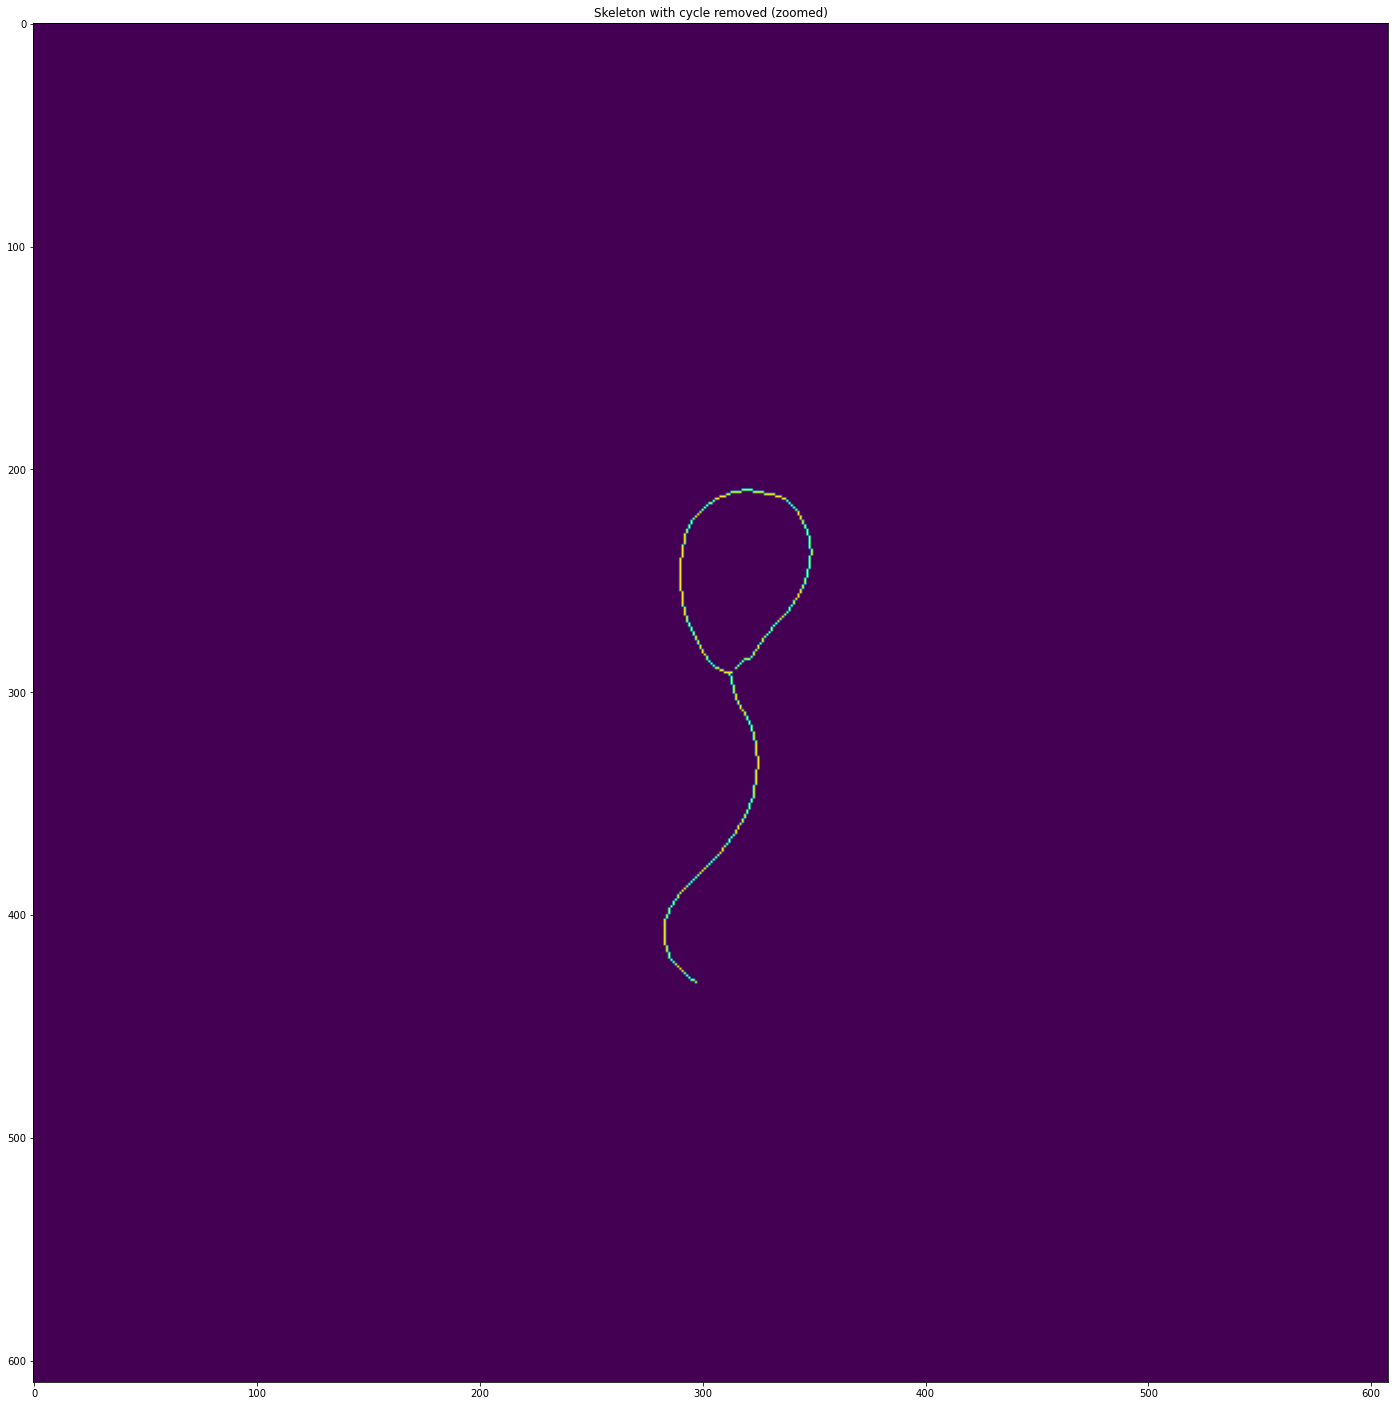

In [18]:
%matplotlib inline
plt.figure(figsize=(45,25))
plt.imshow(img_new)
plt.title("Skeleton with cycle removed (zoomed)")

# Scratch

Text(0.5, 0, 'Degree')

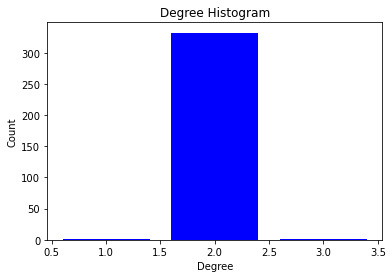

In [40]:
import collections
%matplotlib inline
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")

In [32]:
len(G.nodes())

1247

In [47]:
# from skimage.measure import regionprops

# prop = regionprops(np.array(img_sk, dtype='uint8'))

# sz = prop[0]['bbox']
# print(sz)
# tmp = np.array(img_sk, dtype='uint8')
# img_sk_crop = tmp[sz[0]:sz[1],sz[2]:sz[3]]

# plt.imshow(img_sk_crop)

In [6]:


# def my_img_to_graph(img):
#     # https://github.com/scikit-learn/scikit-learn/blob/95119c13af77c76e150b753485c662b7c52a41a2/sklearn/feature_extraction/image.py#L88
#     # Difference: doesn't take a gradient
    
#     # Base grid graph
#     img = np.atleast_3d(img)
#     n_x, n_y, n_z = img.shape
#     edges = _make_edges_3d(n_x, n_y, n_z)
    
#     # Weights are just if the neighbor is >0
#     dtype = int

#     weights = img.ravel()
#     diag = img.ravel()
#     n_voxels = diag.size

#     # Final graph format
#     diag_idx = np.arange(n_voxels)
#     i_idx = np.hstack((edges[0], edges[1]))
#     j_idx = np.hstack((edges[1], edges[0]))
#     graph = sparse.coo_matrix((np.hstack((weights, weights, diag)),
#                               (np.hstack((i_idx, diag_idx)),
#                                np.hstack((j_idx, diag_idx)))),
#                               (n_voxels, n_voxels),
#                               dtype=dtype)

#     return return_as(graph)